***

# Geothermal Well Test Analysis with Python
### Notebook 2: Temperature log data extraction and interpretation
#### Irene Wallis and Katie McLean 
#### Software Underground, Transform 2021
***

# 4. Introduction to temperature logs

Given that geothermal development seeks to mine heat energy from the Earth, temperature logs are arguably the most important data we acquire. In this tutorial, we will give a short introduction to handling these data and how they are interpreted.

## 4.1 Uses of temperature logs in geothermal exploration and development

- Feed zone identification
- Interpreting well/reservoir events (e.g., heating after drilling or the initiation of a cool reservoir down flow)
- Constraining conceptual models (natural state temperature profiles)
- Calibrating reservoir models

## 4.2 Key considerations when evaluating temperature data

- The well status (shut, injection, flowing) while the log was acquired 
- When the temperature log was acquired (e.g., the time that has elapsed since drilling or since the well was flowed) 
- The thermodynamic conditions inside the well (liquid, two-phase, steam, cold gas)

***

### Google Colab Setup

If you are using Google Colab to run this notebook, we assume you have already followed the Google Colab setup steps outlined [here](https://github.com/ICWallis/T21-Tutoral-WellTestAnalysis).

Because we are importing data, we need to "mount your Google Drive", which is where we tell this notebook to look for the data files. You will need to mount the Google Drive into each notebook.  

1. Run the cell below. If you are not in Google Colab, running the cell below will just return an error that says "No module named 'google'"

2. Follow the link generated by running this code. That link will ask you to sign in to your google account (use the one where you have saved these tutorial materials in) and to allow this notebook access to your google drive. 

3. Completing step 2 above will generate a code. Copy this code, paste below where it says "Enter your authorization code:", and press ENTER. 

Congratulations, this notebook can now import data!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

***

# 5. Extract a completion test temprature log

## 5.1 Use functions to import and munge the PTS and pump data

Install all packages required for this notebook. 

If you do not already have iapws in your environment, then you will need to pip install it. This will need to be done in Google Colab. If you followed the Anaconda setup instructions to make an environment with the environment.yml, then you will not need to do this.

In [ ]:
!pip install iapws

In [1]:
import iapws # steam tables
import openpyxl
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ipywidgets import interactive, Layout, FloatSlider

The data munging process in 1-overview.ipynb has been turned into specilised functions. The cell below contains a set of helper functions

In [2]:


def timedelta_seconds(dataframe_col, test_start):
    '''
    Make a float in seconds since the start of the test

    args:   dataframe_col: dataframe column containing datetime objects
            test_start: test start time formatted '2020-12-11 09:00:00'

    returns: float in seconds since the start of the test
    '''
    test_start_datetime = pd.to_datetime(test_start)
    list = []
    for datetime in dataframe_col:
        time_delta = datetime - test_start_datetime
        seconds = time_delta.total_seconds()
        list.append(seconds)
    return list



def read_flowrate(filename):
    ''' 
    Read PTS-2-injection-rate.xlsx in as a pandas dataframe and munge for analysis

    args: filename is r'PTS-2-injection-rate.xlsx'

    returns: pandas dataframe with local NZ datetime and flowrate in t/hr
    '''
    df = pd.read_excel(filename, header=1) 
    df.columns = ['raw_datetime','flow_Lpm']

    list = []
    for date in df['raw_datetime']:
        newdate = datetime.fromisoformat(date)
        list.append(newdate)
    df['ISO_datetime'] = list 

    list = []
    for date in df.ISO_datetime:
        newdate = pd.to_datetime(datetime.strftime(date,'%Y-%m-%d %H:%M:%S'))
        list.append(newdate)
    df['datetime'] = list

    df['flow_tph'] = df.flow_Lpm * 0.060

    df['timedelta_sec'] = timedelta_seconds(df.datetime, '2020-12-11 09:26:44.448')

    df.drop(columns = ['raw_datetime', 'flow_Lpm', 'ISO_datetime'], inplace = True)

    return df



def read_pts(filename):
    '''
    Read PTS-2.xlsx in as a Pandas dataframe and munge for analysis

    args: filename is r'PTS-2.xlsx'

    returns: Pandas dataframe with datetime (local) and key coloumns of PTS data with the correct dtype
    '''
    df = pd.read_excel(filename)

    dict = {
        'DEPTH':'depth_m',
        'SPEED': 'speed_mps',
        'Cable Weight': 'cweight_kg',
        'WHP': 'whp_barg',
        'Temperature': 'temp_degC',
        'Pressure': 'pressure_bara',
        'Frequency': 'frequency_hz'
    }
    df.rename(columns=dict, inplace=True)

    df.drop(0, inplace=True)
    df.reset_index(drop=True, inplace=True)

    list = []
    for date in df.Timestamp:
        newdate = openpyxl.utils.datetime.from_excel(date)
        list.append(newdate)
    df['datetime'] = list

    df.drop(columns = ['Date', 'Time', 'Timestamp','Reed 0',
       'Reed 1', 'Reed 2', 'Reed 3', 'Battery Voltage', 
       'PRT Ref Voltage','SGS Voltage', 'Internal Temp 1', 
       'Internal Temp 2', 'Internal Temp 3','Cal Temp', 
       'Error Code 1', 'Error Code 2', 'Error Code 3',
       'Records Saved', 'Bad Pages',], inplace = True)
    
    df[
        ['depth_m', 'speed_mps','cweight_kg','whp_barg','temp_degC','pressure_bara','frequency_hz']
    ] = df[
        ['depth_m','speed_mps','cweight_kg','whp_barg','temp_degC','pressure_bara','frequency_hz']
        ].apply(pd.to_numeric)
    
    df['timedelta_sec'] = timedelta_seconds(df.datetime, '2020-12-11 09:26:44.448')

    return df



def append_flowrate_to_pts(flowrate_df, pts_df):
    '''
    Add surface flowrate to pts data

    Note that the flowrate data is recorded at a courser time resolution than the pts data
    The function makes a linear interpolation to fill the data gaps
    Refer to bonus-combine-data.ipynb to review this method and adapt it for your own data

    Args:   flowrate and pts dataframes generated by the read_flowrate and read_pts functions

    Returns: pts dataframe with flowrate tph added
    
    '''
    flowrate_df = flowrate_df.set_index('timedelta_sec')
    pts_df = pts_df.set_index('timedelta_sec')
    combined_df = pts_df.join(flowrate_df, how = 'outer',  lsuffix = '_pts', rsuffix = '_fr')
    combined_df.drop(columns = ['datetime_fr'], inplace = True)
    combined_df.columns = ['depth_m', 'speed_mps', 'cweight_kg', 'whp_barg', 'temp_degC',
       'pressure_bara', 'frequency_hz', 'datetime', 'flow_tph']
    combined_df['interpolated_flow_tph'] = combined_df['flow_tph'].interpolate(method='linear')
    trimmed_df = combined_df[combined_df['depth_m'].notna()]
    trimmed_df.reset_index(inplace=True)
    return trimmed_df



def find_index(value, df, colname):
    '''
    Find the dataframe index for the exact matching value or nearest two values

    args:   value: (float or int) the search term
            df: (obj) the name of the dataframe that is searched
            colname: (str) the name of the coloum this is searched

    returns:  dataframe index(s) for the matching value or the two adjacent values
              rows can be called from a df using df.iloc[[index_number,index_number]]
    '''
    exactmatch = df[df[colname] == value]
    if not exactmatch.empty:
        return exactmatch.index
    else:
        lowerneighbour_index = df[df[colname] < value][colname].idxmax()
        upperneighbour_index = df[df[colname] > value][colname].idxmin()
        return [lowerneighbour_index, upperneighbour_index] 

    

def overview_fig(pts_df,flowrate_df,title=''):
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1,figsize=(10,15),sharex=True)
    ax1.set_title(title,y=1.1,fontsize=15)

    ax1.plot(flowrate_df.datetime, flowrate_df.flow_tph, label='Surface pump flowrate', 
        c='k', linewidth=0.8, marker='.')
    ax1.set_ylabel('Surface flowrate [t/hr]')
    ax1.set_ylim(0,150)
    
    ax2.plot(pts_df.datetime, pts_df.depth_m, label='PTS tool depth', 
        c='k', linewidth=0.8)
    ax2.set_ylabel('PTS tool depth [m]')
    ax2.set_ylim(1000,0)
    
    ax3.plot(pts_df.datetime, pts_df.pressure_bara, label='PTS pressure', 
        c='tab:blue', linewidth=0.8)
    ax3.set_ylabel('PTS pressure [bara]')
    
    ax4.plot(pts_df.datetime, pts_df.temp_degC, label='PTS temperature', 
        c='tab:red', linewidth=0.8)
    ax4.set_ylabel('PTS temperature')
    
    ax5.plot(pts_df.datetime, pts_df.frequency_hz, label='PTS impeller frequency', 
        c='tab:green', linewidth=0.8)
    ax5.set_ylim(-30,30)
    ax5.set_ylabel('PTS impeller frequency [hz]')
    # 1 hz = 60 rpm

    ax6.plot(pts_df.datetime, pts_df.speed_mps, label='PTS tool speed', 
        c='tab:orange', linewidth=0.8)
    ax6.set_ylim(-2,2)
    ax6.set_ylabel('PTS tool speed [mps]')
    
    ax6.set_xlabel('Time [hh:mm]')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
        ax.grid()
    
    return plt

The cells below will take a little while to run because it includes all steps required to import and munge the data (i.e., everything we did in notebook 1).

In [3]:
# Use this method if you are running this notebook in Google Colab
#flowrate = read_flowrate(r'/content/drive/My Drive/T21-Tutoral-WellTestAnalysis-main/Data-FlowRate.xlsx')

# Use this method if you are running this notebook locally (Anaconda)
flowrate = read_flowrate(r'Data-FlowRate.xlsx')

In [4]:
# Use this method if you are running this notebook in Google Colab
#pts = read_pts(r'/content/drive/My Drive/T21-Tutoral-WellTestAnalysis-main/Data-PTS.xlsx')

# Use this method if you are running this notebook locally (Anaconda)
pts = read_pts(r'Data-PTS.xlsx')

In [5]:
print(pts.shape)
pts.head(2)

(101293, 9)


,depth_m,speed_mps,cweight_kg,whp_barg,temp_degC,pressure_bara,frequency_hz,datetime,timedelta_sec
0,-6.32025,NaN,24.957275,-0.607066,19.702093,0.498792,40.648876,2020-12-11 09:26:44.448,0.000
1,-6.32025,NaN,25.211151,-0.606777,19.689250,0.485864,41.483227,2020-12-11 09:26:45.312,0.864


## 5.2 Look at the data

It is good practice to plot data after import so any issues are revealed. 

Note that the temprature logs look a little odd because they include the data aquired while the tool was held stationary for pressure monitoring. 

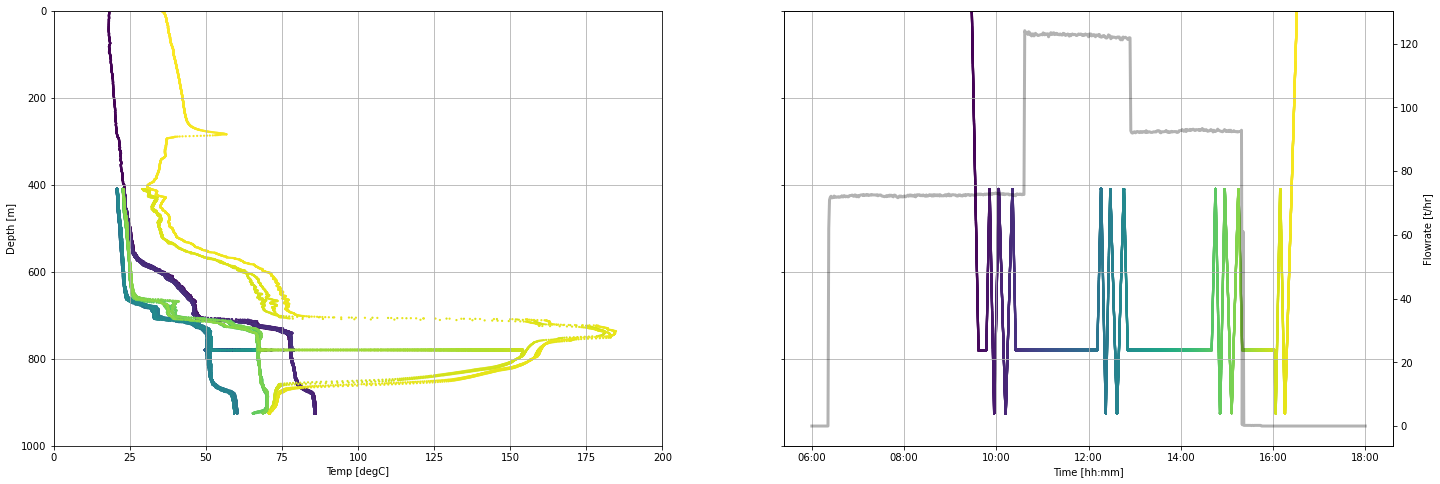

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(24,8),sharey=True)

spinner_scatter = ax1.scatter(pts.temp_degC, pts.depth_m, c = pts.timedelta_sec, s = 5, linewidths = 0)
datetime_scatter = ax2.scatter(pts.datetime, pts.depth_m, c = pts.timedelta_sec, s = 5, linewidths = 0)

ax3 = ax2.twinx()
ax3.plot(flowrate.datetime, flowrate.flow_tph, 
    c='k', linestyle = '-', linewidth = 3, alpha = 0.3, 
    label='Surface pump flowrate')

ax1.set_ylabel('Depth [m]')
ax1.set_xlabel('Temp [degC]')

ax2.set_xlabel('Time [hh:mm]')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax3.set_ylabel('Flowrate [t/hr]')

ax1.set_ylim(1000,0)
ax1.set_xlim(0,200)

for ax in [ax1, ax2]:
    ax.grid()


## 5.3 Remove data acquired when the tool is stationary or slowing

We decided that, in this case, data acquired when the tool is moving down the well at > 0.02 m/s is fast enough to be included. The reasoning behind this method is described in the notebook Bonous-filter-by-toolspeed.ipynb
 
In the cell below, we use a Boolean expression to filter the pts dataframe. Our new working dataframe is called moving_pts 

In [7]:
moving_pts = pts[
    (pts.speed_mps > 0.9 ) & (pts.speed_mps < pts.speed_mps.max()) | 
    (pts.speed_mps > pts.speed_mps.min() ) & (pts.speed_mps < -0.9)
    ]

In [8]:
moving_pts.describe()

,depth_m,speed_mps,cweight_kg,whp_barg,temp_degC,pressure_bara,frequency_hz,timedelta_sec
count,35728.000000,35728.000000,35728.000000,35728.000000,35728.000000,35728.000000,33812.000000,35728.000000
mean,619.309961,0.000889,121.474578,-0.555699,47.128879,23.426249,4.011365,13160.262688
std,184.603047,1.270866,26.823424,0.112767,30.663209,14.852001,13.698449,8729.420412
min,1.970752,-1.539693,25.393188,-0.616755,18.084463,0.059252,-29.385933,85.536000
25%,500.489075,-1.015137,106.350523,-0.612977,24.070804,10.544652,-9.005808,3027.240000
50%,629.704465,-0.979624,123.097855,-0.607455,37.806570,23.132948,9.903941,11724.480000
75%,758.224075,1.312978,139.718280,-0.605516,66.819466,35.503899,16.661721,20631.456000
max,925.073240,1.528768,193.862140,-0.264208,184.733380,51.779540,74.740814,25456.896000


## 5.4 Extract the first heating run from the data

We often want to select a single temperature log for analysis. In this example, we will extract the first heating run (i.e., the temperature log acquired after we stopped pumping into the well)

We will use an interactive tool called ipywidgets to select the start and end time of our desired data range. 

In [9]:
min_timestamp = pts.timedelta_sec.iloc[0]
max_timestamp = pts.timedelta_sec.iloc[-1]

def subselect_plot(start_value, stop_value):
    f,ax = plt.subplots(1,1, figsize = (20,6))
    ax.scatter(moving_pts.timedelta_sec, moving_pts.depth_m,
        c = 'k', s = 1, linewidths = 0, label = 'Tool depth')
    ax1 = ax.twinx()
    ax1.plot(flowrate.timedelta_sec, flowrate.flow_tph, 
        ':', c='k', label='Surface pump flowrate')
    ymin = pts.depth_m.min()
    ymax = pts.depth_m.max() + 100
    ax.vlines(start_value, ymin, ymax, color='tab:green')
    ax.vlines(stop_value, ymin, ymax, color='tab:red')
    ax.set_ylim(pts.depth_m.max() + 100, 0)
    ax.set_xlabel('Timestamp [sec]')
    ax.set_ylabel('Tool depth [m]')
    ax1.set_ylabel('Flowrate [t/hr]')
    ax.set_xlabel('Time elapsed since the test started [sec]')
    ax.set_ylabel('Tool depth [m]')
    ax1.set_ylabel('Flowrate [t/hr]')

result = interactive(subselect_plot,
         
         start_value = FloatSlider
         (
             value = (max_timestamp - min_timestamp)/3 + min_timestamp,
             description = 'start',
             min = min_timestamp, 
             max = max_timestamp, 
             step = 10, 
             continuous_update=False,
             layout = Layout(width='80%'),
             ),
          
          stop_value = FloatSlider
          (
             value = (max_timestamp - min_timestamp)/2 + min_timestamp, 
             description = 'stop',
             min = min_timestamp, 
             max = max_timestamp, 
             step = 10, 
             continuous_update=False,
             layout = Layout(width='80%')
             )
)

display(result);


interactive(children=(FloatSlider(value=8515.296, continuous_update=False, description='start', layout=Layout(…

### Make your selection

Move the sliders above and then run the cell below to return the timestamp at the location of the slider. 

Each time you change this plot, the underlying array of data that we call with the result.children\[x\] statement is changed.

In [11]:
print(
    'start =',result.children[0].value,  
    '\nstop =', result.children[1].value,
    )

start = 24150.0 
stop = 24470.0


### Record your analysis

As part of making this process repeatable and so that it is easy to come back later to check the analysis, you need to use the range you have selected to manually define objects in the next step.

Copy-paste the timestamps printed above into the cell below. They are now the objects that define the start and stop points for splicing the moving_pts dataframe. 

We could have defined the start and stop objects as the result.childern\[0\].value and result.childern\[1\].value objects. But if we did this, you would lose your work because these ipywidget results change every time the sliders are moved or the notebook is re-run. 

In [12]:
# paste your values here
start = 24150.0 
stop = 24470.0

# create an informative title for the data
name = 'First heating run' 

pts_first_heating_run = moving_pts[
    (moving_pts.timedelta_sec > start) 
    & (moving_pts.timedelta_sec < stop)
]

flowrate_first_heating_run = flowrate[
    (flowrate.timedelta_sec > start) 
    & (flowrate.timedelta_sec < stop)
]

In [13]:
pts_first_heating_run.shape

(1216, 9)

The overview_fig function from utilities.py generates a figure that displays our data selection. 

Note that surface flow rate = 0 because this log is acquired after the pumps were shut off. 

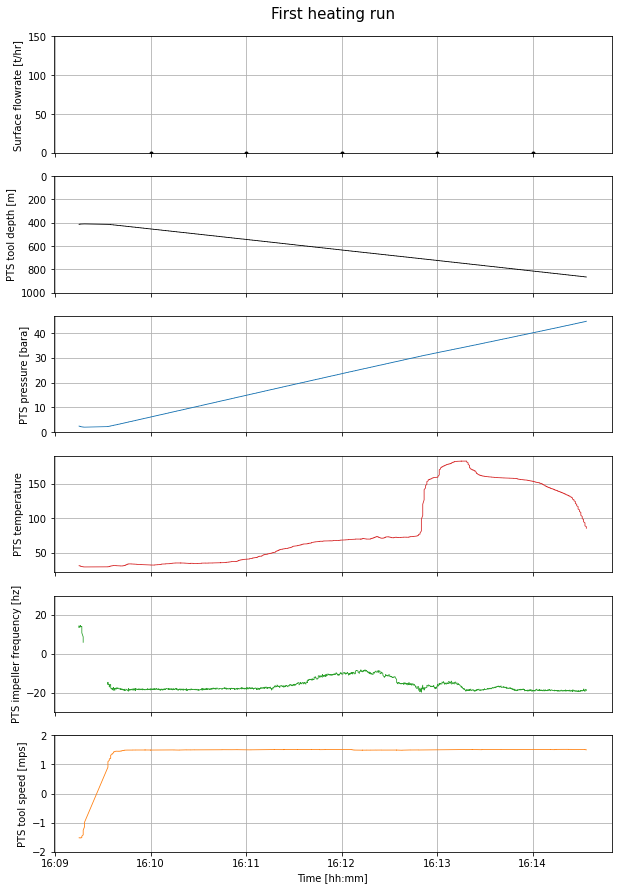

In [14]:
overview_fig(pts_first_heating_run, flowrate_first_heating_run, title = name).show()

### Export data as a csv 

Use the following method to export your selected data to use elsewhere. 

In [ ]:
#pts_first_heating_run.to_csv('Data-Temp-Heating0days.csv', index=False)

## 5.5 Import and calculate contextualising data

We have provided some contextualising data that:
1. Illustrates how geothermal wells heat up over time 
2. Helps us interpret the temperature log we just extracted 

### 5.5.1 Stable temperature

A temperature log was acquired in this well 37 days after it was drilled and tested. In this resource, it reflects the stable temperature of this well. In low permeability settings, wells may take months to fully heat after drilling and testing.

In [15]:

# Use this method if you are running this notebook in Google Colab
#heating_37days = pd.read_csv(r'/content/drive/My Drive/T21-Tutoral-WellTestAnalysis-main/Data-Temp-Heating37days.csv') 

# Use this method if you are running this notebook locally (Anaconda)
heating_37days = pd.read_csv('Data-Temp-Heating37days.csv')

In [16]:
# Convert bar gauge to bar atmosphere

heating_37days['pressure_bara'] = heating_37days.pres_barg - 1

heating_37days.head(2)

,depth_m,whp_barg,pres_barg,temp_degC,pressure_bara
0,0.0,4.019268,3.929268,10.48,2.929268
1,10.5,4.019268,3.929268,10.86,2.929268


### 5.5.2 Saturation temperature aka the boiling point for depth (BPD) curve

Water will boil at a given pressure - temperature condition. We use steam tables to calculate the temperature boiling will occur given the measured pressure. This curve helps us to understand the thermodynamic conditions inside the well. 

The module we use to calculate the BPD is iapws and does not come standard with Anaconda. If you get a 'module not found' error, then return to the top of this notebook and run the iapws installation or pip install it into your Conda environment. 

In [17]:

# note that iapws uses SI units so some unit conversion is required

heating_37days['pressure_mpa'] = heating_37days.pressure_bara * 0.1  # convert pressure to MPa for ipaws

pressure = heating_37days['pressure_mpa'].tolist()
tsat = []
for p in pressure:
    saturation_temp = iapws.iapws97._TSat_P(p) - 273.15  # calculate saturation temp in Kelvin & convert to degC
    tsat.append(saturation_temp)
heating_37days['tsat_degC'] = tsat

heating_37days.head(2)

,depth_m,whp_barg,pres_barg,temp_degC,pressure_bara,pressure_mpa,tsat_degC
0,0.0,4.019268,3.929268,10.48,2.929268,0.292927,132.713496
1,10.5,4.019268,3.929268,10.86,2.929268,0.292927,132.713496


### 5.5.3 Well completion information

Understanding where we are in the well helps us to interpret the data. This is particularly important when we seek to understand what is a process occurring inside the well and what is related to the reservoir. 

In [18]:
production_shoe = 462.5 # 13 3/8 production casing shoe in meters measured depth (mMD) from the casing head flange (CHF)
top_of_liner = 425 # top of perferated 10 3/4 liner in meters measured depth (mMD) from CHF
terminal_depth = 946 # deepest drilled depth 
# the perferated liner is squatted on bottom but didn't quite make it all the way down (bottom of liner is 931 mMD)

### Datums and depth measurements for well test data

The depth of downhole data comes in two forms: 
- Meters measured depth (mMD), which is the number of meters along the well path
- Vertical meters (mVD), which is the number of meters in the vertical dimension 

It is typical for completion test data to be acquired and analysed in measured depth. However, when we seek to understand features of the reservoir, we need to also consider data in vertical depth.  

There are a range of datums that are used in geothermal: 
- During drilling, most data is acquired relative to the rig floor or rotary table
- Well test data acquired after the rig has been demobilised is typically acquired relative to the casing head flange (CHF) or the cellar top (CT), where the latter typically has a survey marker
- Data may also be presented relative to sea level (RSL) or above sea level (ASL)

It is ambiguous to define data relative to ground level (GL) because of the degree of civil construction that occurs on well pads. 

## 5.6 Visualise the data for interpretation



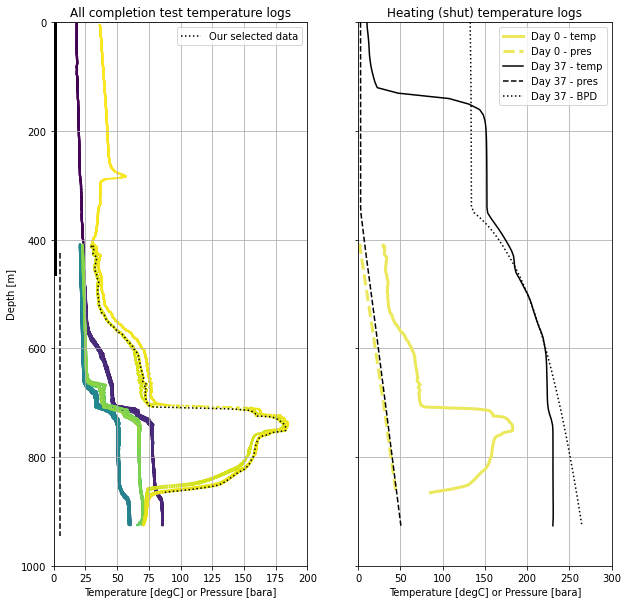

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,10),sharey=True)


ax1.set_title('All completion test temperature logs')

# all temp data colored by time 
ax1.scatter(moving_pts.temp_degC, moving_pts.depth_m,     
    c = moving_pts.timedelta_sec, s = 5, linewidths = 0)

# our sub-selected data
ax1.plot(pts_first_heating_run.temp_degC, pts_first_heating_run.depth_m,
    color = 'k', linestyle = ':', label = 'Our selected data')

# blank well casing
ax1.plot([1, 1],[0, production_shoe],
    color = 'k', linewidth = 3, linestyle = '-')

# perforated well casing
ax1.plot([5, 5],[top_of_liner, terminal_depth],     
    color = 'k', linewidth = 1.5, linestyle = '--')


ax2.set_title('Heating (shut) temperature logs')

# our sub-selected pressure + temp data
ax2.plot(pts_first_heating_run.temp_degC, pts_first_heating_run.depth_m, 
    color ='#EBE85B', linewidth = 3, label = 'Day 0 - temp')

ax2.plot(pts_first_heating_run.pressure_bara, pts_first_heating_run.depth_m, 
    linestyle = '--', linewidth = 3, color = '#EBE85B', label = 'Day 0 - pres')

# stable pressure + temp data
ax2.plot(heating_37days.temp_degC, heating_37days.depth_m, 
    color = 'k', label = 'Day 37 - temp')

ax2.plot(heating_37days.pressure_bara, heating_37days.depth_m, 
    linestyle = '--', color = 'k', label = 'Day 37 - pres')

# saturation temp for the stable pressure
ax2.plot(heating_37days.tsat_degC, heating_37days.depth_m, 
    linestyle = ':', color = 'k', label = 'Day 37 - BPD')


ax1.set_ylim(1000,0) 
ax1.set_ylabel('Depth [m]')
ax1.set_xlim(0,200)
ax1.legend()

ax2.legend()
ax2.set_xlim(0,300)

for ax in [ax1,ax2]:
    ax.set_xlabel('Temperature [degC] or Pressure [bara]')
    ax.grid()


## 6. Temperature in our case study well

This is not a course on how to read temperature logs. However, we can make a couple of quick observations of these data. 

- The injecting temperature profiles are a completely different shape from the heating (shut) profiles. This illustrates the importance of knowing what the well condition was when the temperature log was acquired (i.e., shut, injection, flowing, bleed).
- The two heating (shut) profiles have a completely different shape. This illustrates how important it is to know _when_ the temperature log was acquired relative to operations that impact well temprature (i.e., drilling, injection testing or quenching, flowing, etc). 
- It is heating up the most rapidly just below 700 mMD where two-phase fluid is entering the well. 
- The 37-day heating profile is on the BPD profile from 450-600 mMD, so we would expect two-phase conditions there. The BPD used is for pure water and may not be exact. Below 600 mMD we expect that the well is compressed liquid.


***

© 2021 [Irene Wallis](https://www.cubicearth.nz/) and [Katie McLean](https://www.linkedin.com/in/katie-mclean-25994315/) 

Licensed under the Apache License, Version 2.0

***